## Why SGD?

* In normal gradient descent, we compute the loss against all examples and update gradient across all examples
$$ f(x) = \frac{1}{n}\sum f_i(x) $$

$$ \nabla f(x) = \frac{1}{n}\sum \nabla f_i(x) $$

* computational cost - O(n) : grows with number of examples

* Doesnt suit large datasets -> cost of each epoch will be costly

## SGD

* Update parameter for each example

$$ x = x - \eta \nabla f_i (x) $$

* Computational Cost -> O(1)

* In general, the $\nabla f_i (x)$ is good estimate of the $\nabla f (x)$. But stochastic -> instantaneous gradient are noisy -> oscillate near optimum

* It can be resolved through dynamic learning rate (lower lr)

## MiniBatch GD

* SGD doesnt totally exploit the full power of CPU/GPU, Otherside GD fails esp for large dataset

* Minibatch is the sweet spot betw them

* It involves calculating grads for certain mini batch of dataset

$$ \nabla f = \frac{1}{batch} \sum \nabla f(x_i) $$

* Updates are more reliable aligned (smoother) compared to SGD

* Lets see how vectorization is linked to minibatch processing. 

### Vectorization and its advantages

* Consider A = BC, there are three ways to multiply
    1. Element Wise Assignment (two iterative loops)
    2. Column Wise Assignment
    3. One-go Assignment

In [36]:
import tensorflow as tf
import numpy as np
import time

A = tf.Variable(tf.zeros((256, 256)))
B = tf.Variable(tf.random.normal([256, 256], 0, 1))
C = tf.Variable(tf.random.normal([256, 256], 0, 1))

In [37]:
## Element Wise Assignment 
start_time = time.time()
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        A[i, j].assign(tf.tensordot(B[i, :], C[:, j], axes = 1))
time.time() - start_time

66.38600015640259

In [38]:
## Column Wise Assignment
start_time = time.time()
for j in range(A.shape[0]):
    A[:, j].assign(tf.tensordot(B, C[:, j], axes=1))
time.time() - start_time

0.33499979972839355

In [39]:
## One time Assignment
start_time = time.time()
A.assign(tf.tensordot(B, C, axes=1))
time.time() - start_time

0.014000177383422852

### Vectorization & Minibatch GD

* SGD involves single order calculations which could be expensive considering Vectorization benefits

* In minibatch, the grad calculation using vectorization

* Minibatch stochastic gradient descent offers the best of both worlds: computational and statistical efficiency.

## Implementation from Scratch

In [143]:
## Using NASA data to test wing noise from aircraft
data = np.genfromtxt(r'data\airfoil_self_noise.dat', dtype = np.float32, delimiter = '\t')
# data = (data - data.mean(axis = 0)) / data.std(axis = 0)
n = 500 # reading top rows
xtrain, ytrain = data[:n, :-1], data[:n, -1]

xtrain = (xtrain - xtrain.mean(axis = 0)) / xtrain.std(axis = 0)

In [146]:
def load_array(features, batch_size, is_train = True):
    data = tf.data.Dataset.from_tensor_slices(features)
    # data = data.shuffle(buffer_size = 1000)
    data = data.batch(batch_size)
    return data

In [167]:
def sgd(params, grads, lr):
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad)

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

In [168]:
def train_model(xtrain, ytrain, batch_size, num_epoch, lr):
    
    data_iter = load_array((xtrain, ytrain), batch_size, is_train=True)

    lin_reg = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
    ])
    training_loss = []
    for epoch in range(num_epoch):
        for X, y in data_iter:
            with tf.GradientTape() as tape:
                yhat = lin_reg(X)
                mse = loss(y, yhat)
            
            params = lin_reg.trainable_variables
            grads = tape.gradient(mse, params)
            optimizer.apply_gradients(zip(grads,params))
            
            # sgd(params, grads, lr)

        epoch_loss = loss(ytrain, lin_reg(xtrain)).numpy()
        training_loss.append(epoch_loss)
    return training_loss

In [169]:
def lin_reg(X, w, b):
    return tf.matmul(X, w) + b

In [170]:
def train_model(xtrain, ytrain, batch_size, num_epoch, lr):
    
    data_iter = load_array((xtrain, ytrain), batch_size, is_train=True)
    
    w = tf.Variable(tf.random.normal(shape=(xtrain.shape[1], 1),
                                   mean=0, stddev=0.01),trainable=True)
    b = tf.Variable(tf.zeros(1), trainable=True)
    
    training_loss = []
    for epoch in range(num_epoch):
        for X, y in data_iter:
            with tf.GradientTape() as tape:
                yhat = lin_reg(X, w, b)
                mse = loss(y, yhat)
            
            dw, db = tape.gradient(mse, [w, b])
            sgd([w, b], [dw, db], lr)
            
        epoch_loss = loss(ytrain, lin_reg(xtrain, w, b)).numpy()
        training_loss.append(epoch_loss)
    return training_loss

In [178]:
num_epoch = 200
gd_model = train_model(xtrain, ytrain, batch_size = len(ytrain), num_epoch = num_epoch, lr = 0.05)
sgd_model = train_model(xtrain, ytrain, batch_size = 1, num_epoch = num_epoch, lr = 0.05)
minibatch_gd_model = train_model(xtrain, ytrain, batch_size = 32, num_epoch = num_epoch, lr = 0.05)

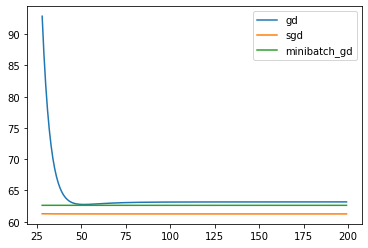

In [180]:
import matplotlib.pyplot as plt
plt.plot(np.arange(num_epoch)[28:], gd_model[28:], label = 'gd')
plt.plot(np.arange(num_epoch)[28:], sgd_model[28:], label = 'sgd')
plt.plot(np.arange(num_epoch)[28:], minibatch_gd_model[28:], label = 'minibatch_gd')
plt.legend()